<a href="https://colab.research.google.com/github/AnmolMohak/Fraud_dectection_unsupervised/blob/main/Fraud_Transaction_Stepchange.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [104]:
# importing essential libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# importing clustering libraries
from sklearn.cluster import KMeans

# importing feature scaling libraries.
from sklearn.preprocessing import StandardScaler

In [105]:
from sklearn.ensemble import IsolationForest
from sklearn.mixture import GaussianMixture

from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report, recall_score, precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import make_scorer, f1_score
from sklearn.metrics import silhouette_score

In [106]:

data=pd.read_csv("/content/financial_anomaly_data.csv")
data.head()


,Timestamp,TransactionID,AccountID,Amount,Merchant,TransactionType,Location
0,01-01-2023 08:00,TXN1127,ACC4,95071.92,MerchantH,Purchase,Tokyo
1,01-01-2023 08:01,TXN1639,ACC10,15607.89,MerchantH,Purchase,London
2,01-01-2023 08:02,TXN872,ACC8,65092.34,MerchantE,Withdrawal,London
3,01-01-2023 08:03,TXN1438,ACC6,87.87,MerchantE,Purchase,London
4,01-01-2023 08:04,TXN1338,ACC6,716.56,MerchantI,Purchase,Los Angeles


In [107]:
data.drop_duplicates(inplace=True)
print (data.shape)

(216961, 7)


In [108]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 216961 entries, 0 to 216960
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Timestamp        216960 non-null  object 
 1   TransactionID    216960 non-null  object 
 2   AccountID        216960 non-null  object 
 3   Amount           216960 non-null  float64
 4   Merchant         216960 non-null  object 
 5   TransactionType  216960 non-null  object 
 6   Location         216960 non-null  object 
dtypes: float64(1), object(6)
memory usage: 13.2+ MB


In [109]:
data.isnull().sum

<bound method NDFrame._add_numeric_operations.<locals>.sum of         Timestamp  TransactionID  AccountID  Amount  Merchant  \
0           False          False      False   False     False   
1           False          False      False   False     False   
2           False          False      False   False     False   
3           False          False      False   False     False   
4           False          False      False   False     False   
...           ...            ...        ...     ...       ...   
216956      False          False      False   False     False   
216957      False          False      False   False     False   
216958      False          False      False   False     False   
216959      False          False      False   False     False   
216960       True           True       True    True      True   

        TransactionType  Location  
0                 False     False  
1                 False     False  
2                 False     False  
3            

In [110]:
data.dropna(inplace=True)

In [111]:
data.shape

(216960, 7)

In [112]:
data.isnull().values.sum()


0

In [113]:
data.columns

Index(['Timestamp', 'TransactionID', 'AccountID', 'Amount', 'Merchant',
       'TransactionType', 'Location'],
      dtype='object')

In [114]:
from sklearn.preprocessing import LabelEncoder
encoder=LabelEncoder()


In [115]:
data['Location']=encoder.fit_transform(data['Location'])
data['TransactionType']=encoder.fit_transform(data['TransactionType'])


In [116]:
data.head()

,Timestamp,TransactionID,AccountID,Amount,Merchant,TransactionType,Location
0,01-01-2023 08:00,TXN1127,ACC4,95071.92,MerchantH,0,4
1,01-01-2023 08:01,TXN1639,ACC10,15607.89,MerchantH,0,0
2,01-01-2023 08:02,TXN872,ACC8,65092.34,MerchantE,2,0
3,01-01-2023 08:03,TXN1438,ACC6,87.87,MerchantE,0,0
4,01-01-2023 08:04,TXN1338,ACC6,716.56,MerchantI,0,1


for Location  0--> London, 1--> Los Angeles, 2--->NewYork, 3--->San Francisco  ,4---> Tokyo

for Transaction Type 0--> Purchase, 1--> Transfer ,2--->Withdrawal

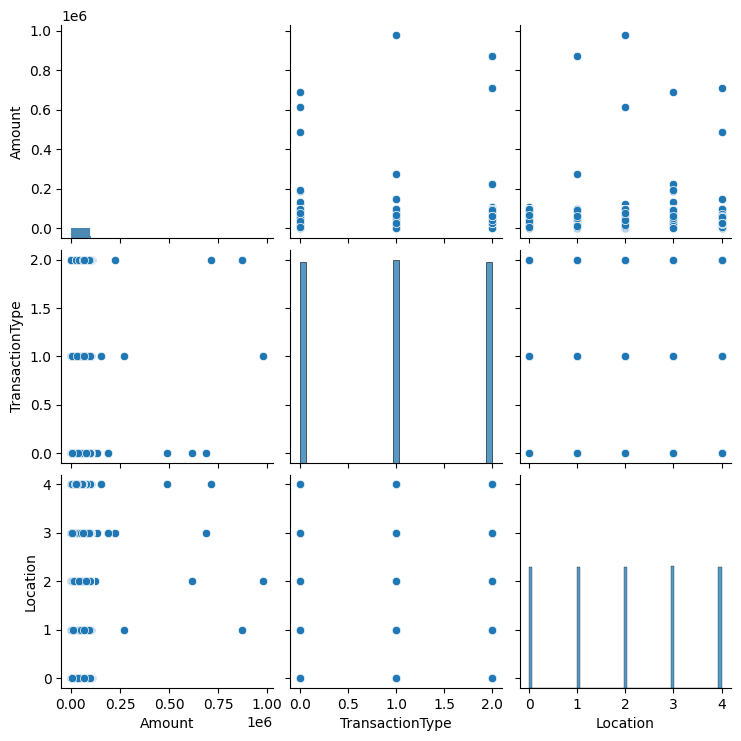

In [117]:
sns.pairplot(data)
plt.show()

In [118]:
data.corr()

<ipython-input-118-c44ded798807>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  data.corr()


,Amount,TransactionType,Location
Amount,1.000000,-0.002611,0.001978
TransactionType,-0.002611,1.000000,-0.000271
Location,0.001978,-0.000271,1.000000


In [119]:
columns_to_drop = ['Timestamp', 'TransactionID','Merchant','AccountID']
data.drop(columns=columns_to_drop, inplace=True)

In [120]:
data.head()

,Amount,TransactionType,Location
0,95071.92,0,4
1,15607.89,0,0
2,65092.34,2,0
3,87.87,0,0
4,716.56,0,1


In [121]:
X = data

In [122]:
# Calculate the IQR for each column
Q1 = X.quantile(0.25)
Q3 = X.quantile(0.75)
IQR = Q3 - Q1

# Define the threshold multiplier
threshold = 1.5

# Calculate the lower and upper bounds for each column
lower_bound = Q1 - threshold * IQR
upper_bound = Q3 + threshold * IQR

X_iqr = X[~((X < lower_bound) | (X > upper_bound)).any(axis=1)]
X_out = X[((X < lower_bound) | (X > upper_bound)).any(axis=1)]

print('X - Fitting dataset shape: ', X.shape)
print('X_iqr - Fitting dataset without outliers shape: ', X_iqr.shape)
print('X_out - Fitting dataset with outliers shape: ', X_out.shape)

X - Fitting dataset shape:  (216960, 3)
X_iqr - Fitting dataset without outliers shape:  (216949, 3)
X_out - Fitting dataset with outliers shape:  (11, 3)


In [123]:
data['Outlier']=(~data.index.isin(X_iqr.index)).astype(int)
data['Outlier_num'] = ((X < lower_bound) | (X > upper_bound)).sum(axis=1)

<ipython-input-123-a017dfcc96ca>:2: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  data['Outlier_num'] = ((X < lower_bound) | (X > upper_bound)).sum(axis=1)


In [124]:
# Initiate Isolation Forest model
Iforest = IsolationForest(
                        random_state=1111,
                        max_samples='auto',
                        contamination='auto',
                        max_features=1.0, #1.0 - all features in df are used
                        n_estimators=100,
                        bootstrap = True
                        )

In [125]:
# Fit the model
Iforest.fit(X)

# Predict the anomaly class. Class = -1 indicates an anomaly. Class = 1 - normal instance
y_pred = Iforest.predict(X)
# Adjust the anomaly class value to 1- an anomal; 0 - not an anomaly
y_pred_adjusted = [1 if x == -1 else 0 for x in y_pred]
# Calculate prediction score
y_pred_score = Iforest.decision_function(X)

# Record the predicted class and the score in data_result dataframe
data['Class_IForest']=pd.Series(y_pred_adjusted)
data['Score_IForest']=pd.Series(y_pred_score)

In [126]:
print('Number of detected anomalies :', data['Class_IForest'].sum())

Number of detected anomalies : 214538


GMM

In [127]:
# Initiate GMM model
gmm = GaussianMixture(
    n_components =2,
    n_init = 5,
    random_state = 1111
)

In [128]:
#Fit_predict the model
y_pred = gmm.fit_predict(X)
# Calculate prediction score
y_pred_score = gmm.score_samples(X)

# Record the score in data_result dataframe
data['Score_GMM']=pd.Series(y_pred_score)

In [129]:
import numpy as np

In [130]:
# Calculate the score threshold for anomaly
# cont_assumed - assumed contamination level in %

cont_assumed = 2 #in %
cont_threshold = np.percentile(y_pred_score, cont_assumed)
print ('The comtamination score threshold: ', cont_threshold)

# Label the anomalies
data['Class_GMM']=data['Score_GMM'].apply(lambda x: 1 if x < cont_threshold else 0)

The comtamination score threshold:  -0.7185785501363458


In [131]:
print('Number of detected anomalies :', data['Class_GMM'].sum())

Number of detected anomalies : 4340


In [132]:
data.head()

,Amount,TransactionType,Location,Outlier,Outlier_num,Class_IForest,Score_IForest,Score_GMM,Class_GMM
0,95071.92,0,4,0,0,1,-0.102364,0.633476,0
1,15607.89,0,0,0,0,1,-0.066725,2.359949,0
2,65092.34,2,0,0,0,1,-0.067717,3.063187,0
3,87.87,0,0,0,0,1,-0.128607,-2.686863,1
4,716.56,0,1,0,0,1,-0.099784,0.657869,0
